# ICSOS paper (not updated)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from copy import deepcopy
from pyproj import Proj, Geod
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

### definition functions for the parameters calculate

In [2]:
# parameter equation for u
def para_u(p_u,u):
    pu0,pu1,pu2,pu3,pu4,pu5,pu6,pu7 = p_u
    du = pu0*u[0] + pu1*u[1]+ pu2*u[2] + pu3*u[3] + pu4*u[4] + pu5*u[5] + pu6*u[6] + pu7*u[7]
    return du
def error_u(p_u, u, du):
    return para_u(p_u,x) - du

# parameter equation for v
def para_v(p_v,v):
    pv0,pv1,pv2,pv3,pv4,pv5,pv6,pv7,pv8,pv9,pv10,pv11,pv12,pv13 = p_v
    dv = pv0*v[0] + pv1*v[1] + pv2*v[2] + pv3*v[3] + pv4*v[4] + pv5*v[5] + pv6*v[6] + pv7*v[7] + pv8*v[8] + pv9*v[9] + pv10*v[10] + pv11*v[11] + pv12*v[12] + pv13*v[13]
    return dv
def error_v(p_v, v, dv):
    return para_v(p_v,x) - dv

# parameter equation for r
def para_r(p_r,r):
    pr0,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr9,pr10,pr11,pr12,pr13 = p_r
    dr = pr0*r[0] + pr1*r[1] + pr2*r[2] + pr3*r[3] + pr4*r[4] + pr5*r[5] + pr6*r[6] + pr7*r[7] + pr8*r[8] + pr9*r[9] + pr10*r[10] + pr11*r[11] + pr12*r[12] + pr13*r[13]
    return dr
def error_r(p_r, r, dr):
    return para_r(p_r,x) - dr

### load zigzag data and pretreatment

In [3]:
# data = pd.read_csv("./model_data/trunning_30_inter.csv")
data = pd.read_csv("./model_data/zigzag_30_inter.csv")
data.speed = data.speed / 1.852
service_speed = round(data.speed.mean(), 3)

FileNotFoundError: [Errno 2] No such file or directory: './model_data/zigzag_30_inter.csv'

In [76]:
# no course data, use the diff heading instead
d_heading = data.heading.diff().fillna(0)
data.loc[:,"dcourse"] = d_heading

# calculate the rudder angle and heading
data.loc[:,"rudder"] = np.deg2rad(data.rudder-40)
data.loc[:,"heading"] = np.deg2rad(data.heading)

# calculate the u, v and r
data.loc[:,"u"] = np.cos(np.deg2rad(d_heading)) * data.speed - service_speed
data.loc[:,"v"] = np.sin(np.deg2rad(d_heading)) * data.speed
data.loc[:,"r"] = data.heading.diff().fillna(0)
# trans longitude and latitude to x y (m)
trans_cor = Proj(proj='utm', zone=10, ellps='WGS84', preserve_units=False)
x,y = trans_cor(data.lon.values, data.lat.values)
dx = x - x[0]
dy = y - y[0]
data.loc[:,"x"] = dx
data.loc[:,"y"] = dy

# data.loc[:,"du"] = data.u.diff().fillna(0)
# data.loc[:,"dv"] = data.v.diff().fillna(0)
# data.loc[:,"dr"] = data.r.diff().fillna(0)
# rudder?
# data.loc[:,"drudder"] = data.ruddera.diff().fillna(0)

### Abkoitz model test

In [ ]:
# 加速度带入计算 求得加速度
# 再在时间上积分
# du, dv, dr,de(rudder)

In [116]:
### raw 60 paramerters
### simplify to 36 parameters (8+14+14)
### kt models

In [ ]:
# ship = [x, y, u, v, r, e, heading]

In [61]:
def Abkoitz_36Param(data):
    """
    Abkoitz with 36 parameters(u: 8, v:14, r: 14)
    input: dataframe with the u,v,r,drudder (speed in m/s, angle in radian)
    output: paramerers for u, v, r
    """
    # get the u / v / r data from the dataframe
    u = data.u.values
    v = data.v.values
    r = data.r.values
    rudder = data.rudder.values
#     drudder = data.drudder.values

    # calculate the input( du / dv / dr )
    du = [u, v**2, r**2, rudder**2, v*r, v*rudder, r*rudder, 1]
    dv = [v, r, rudder, abs(v)*v, abs(v)*r, abs(r)*r, abs(r)*v,\
          rudder**3, v**2*rudder, v*rudder**2, r*rudder**2, r**2*rudder, r*u*rudder,1]
    dr = [v, r, rudder, abs(v)*v, abs(v)*r, abs(r)*r, abs(r)*v,\
          rudder**3, v**2*rudder, v*rudder**2, r*rudder**2, r**2*rudder, r*u*rudder,1]
    # defini the min error
    ue = np.zeros(8)
    ve = np.zeros(14)
    re = np.zeros(14)

    # calculate the output( dot_u / dot_v / dot_r)
    h = 0.1
    dot_u = data.u.diff().fillna(0)/h
    dot_v = data.v.diff().fillna(0)/h
    dot_r = data.r.diff().fillna(0)/h

    # latest square method calculate the parameters
    parau = leastsq(error_u,ue,args=(u,dot_u))
    parav = leastsq(error_v,ve,args=(v,dot_v))
    parar = leastsq(error_r,re,args=(r,dot_r))
    Param = dict(Pu=parau[0], Pv=parav[0], Pr=parar[0])
    return Param

In [30]:
dship = np.zeros((8))
Pu = Param['Pu']
Pv = Param['Pv']
Pr = Param['Pr']
# x
dship[0] = (ship[2] + service_speed)*np.cos(ship[4]) - (ship[3]*np.sin(ship[4]))
# y
dship[1] = (ship[2] + service_speed)*np.sin(ship[4]) + (ship[3]*np.cos(ship[4]))
# du
dship[2] = Pu[0]*ship[2] + Pu[1]*ship[3]**2 + Pu[2]*ship[4]**2 + Pu[3]*ship[5]**2 \
            + Pu[4]*ship[3]*ship[4] + Pu[5]*ship[3]*ship[5] + Pu[6]*ship[4]*ship[5] + Pu[7]
# dv
dship[3] = Pv[0]*ship[3] + Pv[1]*ship[4] + Pv[2]*ship[5] + Pv[3]*abs(ship[3])*ship[3] \
            + Pv[4]*abs(ship[3])*ship[4] + Pv[5]*abs(ship[4])*ship[4] + Pv[6]*abs(ship[3])*ship[4] \
            + Pv[7]*(ship[5])**3 + Pv[8]*ship[3]**2*ship[5] + Pv[9]*ship[3]*ship[5]**2 \
            + Pv[10]*ship[4]*ship[5]**2 + Pv[11]*ship[4]**2*ship[5] + Pv[12]*ship[2]*ship[4]*ship[5] + Pv[13]
# dr
dship[4] = Pr[0]*ship[3] + Pr[1]*ship[4] + Pr[2]*ship[5] + Pr[3]*abs(ship[3])*ship[3] \
            + Pr[4]*abs(ship[3])*ship[4] + Pr[5]*abs(ship[4])*ship[4] + Pr[6]*abs(ship[3])*ship[4] \
            + Pr[7]*(ship[5])**3 + Pr[8]*ship[3]**2*ship[5] + Pr[9]*ship[3]*ship[5]**2 \
            + Pr[10]*ship[4]*ship[5]**2 + Pr[11]*ship[4]**2*ship[5] + Pr[12]*ship[2]*ship[4]*ship[5] + Pr[13]
# de
dship[5] =  ship[7]

In [ ]:
# ship = [x, y, u, v, r, e, heading]

In [121]:
def Abkowitz_36model(Param, ship):
    """
        Param: dict, include the parameters for the Pu, Pv and Pr
        ship: list, include the ship's x, y, u, v, r, e, heading data
    """
    shipx, shipy, shipu, shipv, shipr, shipe ,shiph= ship
    # ship = [x, y, u, v, r, e, heading]
    dship = np.zeros((7))
    Pu = Param['Pu']
    Pv = Param['Pv']
    Pr = Param['Pr']
    # x
    dship[0] = (shipu + service_speed)*np.cos(shiph) - (shipv*np.sin(shiph))
    # y
    dship[1] = (shipu + service_speed)*np.sin(shiph) + (shipv*np.cos(shiph))
    # du
    dship[2] = Pu[0]*shipu + Pu[1]*shipv**2 + Pu[2]*shipr**2 + Pu[3]*shipe**2 \
                + Pu[4]*shipv*shipr + Pu[5]*shipv*shipe + Pu[6]*shipr*shipe + Pu[7]
    # dv
    dship[3] = Pv[0]*shipv + Pv[1]*shipr + Pv[2]*shipe + Pv[3]*abs(shipv)*shipv \
                + Pv[4]*abs(shipv)*shipr + Pv[5]*abs(shipr)*shipr + Pv[6]*abs(shipr)*shipv \
                + Pv[7]*(shipe)**3 + Pv[8]*shipv**2*shipe + Pv[9]*shipv*shipe**2 \
                + Pv[10]*shipr*shipe**2 + Pv[11]*shipr**2*shipe + Pv[12]*shipr*shipv*shipe + Pv[13]
    # dr
    dship[4] = Pr[0]*ship[3] + Pr[1]*ship[4] + Pr[2]*ship[5] + Pr[3]*abs(ship[3])*ship[3] \
                + Pr[4]*abs(ship[3])*ship[4] + Pr[5]*abs(ship[4])*ship[4] + Pr[6]*abs(ship[3])*ship[4] \
                + Pr[7]*(ship[5])**3 + Pr[8]*ship[3]**2*ship[5] + Pr[9]*ship[3]*ship[5]**2 \
                + Pr[10]*ship[4]*ship[5]**2 + Pr[11]*ship[4]**2*ship[5] + Pr[12]*ship[2]*ship[4] + Pr[13]
    # dheading
    dship[6] = shipr
    return dship

In [124]:
def euler2(xdot, x, delta_t):
    return (x + xdot*delta_t)

In [137]:
Param = Abkoitz_36Param(data)
dt = .1
predict = []
ship = data[["x","y","u","v","r","rudder","heading"]].loc[0].values
predict.append(ship)
for i in range(len(data)):
    rudder = data.rudder[i]
#     rpm = choose.rpm[i]
#     ship[5] = rpm
    ship[6] = rudder
    dx = Abkowitz_36model(Param, ship)
    ship = deepcopy(euler2(dx, deepcopy(ship), dt))
    predict.append(ship)
predict = pd.DataFrame(predict,columns=["x","y","u","v","r","rudder","heading"])  

In [146]:
predict

,x,y,u,v,r,rudder,heading
0,0.000000,0.000000,0.003978,0.000000e+00,0.000000e+00,0.531089,0.531089
1,0.054838,0.032211,0.003978,-1.221162e-08,1.332594e-08,0.531089,0.532008
2,0.109646,0.064472,0.003978,-2.442325e-08,2.665188e-08,0.531089,0.532831
3,0.164427,0.096778,0.003978,-3.663487e-08,3.997782e-08,0.531089,0.533652
4,0.219182,0.129129,0.003978,-4.884650e-08,5.330376e-08,0.531089,0.534458
...,...,...,...,...,...,...,...
2092,116.214405,1.948242,0.003995,-2.554642e-05,2.787780e-05,0.531089,0.498714
2093,116.270260,1.978659,0.003995,-2.555863e-05,2.789112e-05,0.531089,0.498714
2094,116.326114,2.009076,0.003995,-2.557085e-05,2.790445e-05,0.531089,0.498714
2095,116.381968,2.039493,0.003995,-2.558306e-05,2.791777e-05,0.531089,0.498714


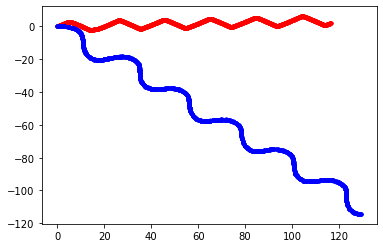

In [138]:
plt.plot(predict.x, predict.y, "r.")
plt.plot(data.x,data.y, "b.")

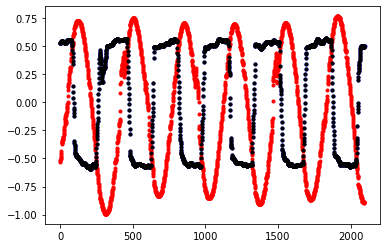

In [151]:
plt.plot(xx1.heading, "b.")
plt.plot(data.heading,  "r.")
plt.plot(data.rudder,  "k.")

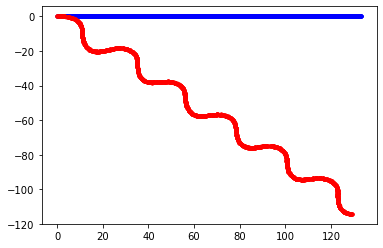

In [82]:
plt.plot(xx1.x, xx1.y, "b.")
plt.plot(data.x, data.y, "r.")

### latest square fucntion test 

In [154]:
Xi=np.array([6.19,2.51,7.29,7.01,5.7,2.66,3.98,2.5,9.1,4.2])
Yi=np.array([5.25,2.83,6.41,6.71,5.1,4.23,5.05,1.98,10.5,6.3])

In [155]:
# 拟合函数
def func(p,x):
    k,b=p
    return k*x+b

# 误差函数
def error(p,x,y):
    return func(p,x)-y

In [158]:
p0=[1,20]
Para = leastsq(error,p0,args=(Xi,Yi))

In [159]:
k,b=Para[0]
print("k=",k,"b=",b)
print("cost："+str(Para[1]))
print("y="+str(round(k,2))+"x+"+str(round(b,2)))

k= 0.9004584204388926 b= 0.831055638876812
cost：1
y=0.9x+0.83


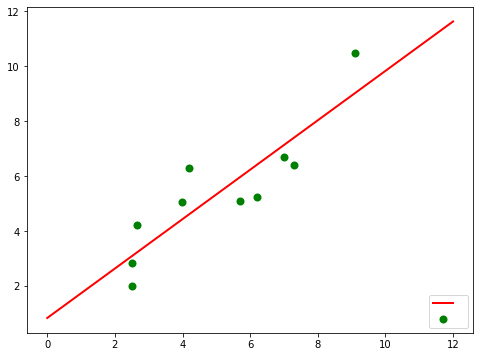

In [160]:
plt.figure(figsize=(8,6)) ##指定图像比例： 8：6
plt.scatter(Xi,Yi,color="green",label=" ",linewidth=2) 

#画拟合直线
x=np.linspace(0,12,100) ##在0-15直接画100个连续点
y=k*x+b ##函数式
plt.plot(x,y,color="red",label=" ",linewidth=2) 
plt.legend(loc='lower right') #绘制图例
plt.show()